In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from tqdm import tqdm
import sys

p = Path('.').resolve()
sys.path.append(str(p.parent))

In [2]:
from utils.data_utils import *
from utils.faiss_utils import *

Loading faiss with AVX2 support.


In [3]:
def load_XY(basename):
    """
    Load embeddings (X) and possibly the
    labels (Y) of the graph {basename}.
    """
    model_path = Path("/data/models") / basename
    print("Loading data..")
    X, Y = load_data(model_path)
    classes = len(np.unique(Y))
    print("X shape: {}".format(X.shape))
    return X, Y

In [13]:
def iter_embeddings(model_path, h5=True):
    """
    updated version of iter_partitions
    NOTICE: returns objects NOT ordered
    """
    temp = []
    if h5:
        for h5_file in model_path.glob('embeddings_link*.h5'):
            temp.append(h5_file)
    else:
        for json_file in model_path.glob('entity_names_link_*.json'):
            temp.append(json_file)
    temp = sorted(temp)
    for i in temp:
        yield i

In [17]:
import json


def get_entities_list(basename):
    entities_list = []
    model_path = Path("/data/models") / basename
    for json_f in iter_embeddings(model_path, h5=False):
        with json_f.open() as f:
            # with open(json_f, "rt") as f:
            entities = json.load(f)
        entities_list += [int(i) for i in entities]
    return entities_list

In [15]:
basename = "enwiki-2016"
x, y = load_XY(basename)
x.shape

Loading data..
Labels not defined
Labels not defined
Labels not defined
Labels not defined
Labels not defined
Labels not defined
Labels not defined
Labels not defined
Labels not defined
Labels not defined
Labels not defined
Labels not defined
Labels not defined
Labels not defined
Labels not defined
Labels not defined
Labels not defined
Labels not defined
Labels not defined
Labels not defined
X shape: (5088560, 128)


(5088560, 128)

In [ ]:
enwiki_kmeans = kmeans(x, 50, niter=10000)

In [19]:
entities = get_entities_list(basename)
centroid_neigh("enwiki-2016", enwiki_kmeans, x, entities, n=5)

 Cluster 0 
Arthur Randall

Second Battle of Heligoland Bight

HMS Calcutta (D82)

Vincent Barkly Molteno

Battle of Crete order of battle

 Cluster 1 
Load balancing (computing)

Application layer

Simple Network Management Protocol

Continuous delivery

Data recovery

 Cluster 2 
Instrument (To Rococo Rot album)

Change of Skin

Serpentine Gallery (album)

The Party Scene

Everybody Knows (The Young Gods album)

 Cluster 3 
2012 Hathazari violence

List of places in Peshawar

Bengali Language Movement

Chaudhry Niaz Ali Khan

Chichawatni

 Cluster 4 
The Line of Beauty (TV series)

Judy Loe

Victoria Wood As Seen On TV

The Go-Between (2015 TV film)

Shoestring (TV series)

 Cluster 5 
Rest frame

Pugh–Schiff precession

Clock-comparison experiment

AQUAL

N-body simulation

 Cluster 6 
Texas A&M Aggies softball

List of Southeastern Conference national championships

Joe Bauserman

Rollie Seltz

Western Carolina Catamounts

 Cluster 7 
Sciotropis

Crocyllis

Hypolestes

Dioicodendro

# Build categories dictionary

In [26]:
cat_file = Path("/data/graphs") / basename / "page2cat.tsv"
cat_file.exists()

True

In [37]:
from collections import defaultdict


categories = defaultdict(set)
for pos, line in enumerate(cat_file.open(encoding="utf-8")):
    temp = line.rstrip().split("\t")
    key, cat = temp[0], set(temp[1:])
    categories[key] = cat


len(categories)

3726309

In [39]:
def jaccard_sim(s1, s2):
    assert type(s1) == type(s2) == set, "only taking sets as input"
    return len(s1 & s2) / len(s1 | s2)


s1 = set([1, 2, 3])
s2 = set([3, 4, 5])
jaccard_sim(s1, s2)

0.2

In [49]:
for pos, key in enumerate(categories):
    print(key)
    if pos > 50:
        break

Anarchism
Değnek
Queensland Conservatorium Griffith University
Octagon Chapel, Liverpool
Radha Mohan
Thomas Craig (jurist)
Microsorum vieillardii
Princess Augusta Sophia of the United Kingdom
Derek Thompson (baseball)
Battle of the Coral Sea (film)
Carvone
Red-tailed monkey
2003 MAC Men's Basketball Tournament
Louis Franchet d'Espèrey
Benjamin Tuke
Cornelis de Bie
Washington State Legislature
Đàn đá
Issa (Senegalese singer)
William Johnston Tupper
Saint Vincent Academy
Bonkers (song)
Principal axis
Thomas Jones (historian)
Show Us Your Tiddas!
LOA
The Last Days of the Late, Great State of California
Aladdin (1992 Golden Films film)
Alejandro Ibarra
Banbury
Swimming at the 1992 Summer Olympics – Men's 100 metre breaststroke
Underdown
Dreaming Lips
Escrow
Aída Álvarez
Mulberry High School
Anaxagoras (disambiguation)
Cretinism
Nenad Petrović (chess composer)
Construction Clients' Group
Gmina Osieczna, Pomeranian Voivodeship
Mikołaj Gomółka
Academy at Central
The Fourth Legacy
Wonderful Sh

In [75]:
ids_file = Path('/data/graphs/') / basename / (basename + '.ids')
counter = 0
for pos, line in enumerate(ids_file.open(encoding="utf-8")):
    if line.rstrip() in categories:
        counter += 1
        
counter / pos

0.7300076958004319

# Link to categories

In [76]:
def find_neighbours(basename, idx, ent_list):
    ids_file = Path('/data/graphs/') / basename / (basename + '.urls')
    if not ids_file.exists():
        ids_file = Path('/data/graphs/') / basename / (basename + '.ids')
    assert ids_file.exists(), "File not found!"
    f = ids_file.as_posix()
    for node in idx:
        line = ent_list[node]
        yield linecache.getline(f, line + 1).rstrip()

In [142]:
n = 100
subset = np.random.choice(len(x), n, replace=False)
titles = [i for i in find_neighbours("enwiki-2016", subset, entities)]
len(titles)

100

In [143]:
indices = []
for pos, value in enumerate(titles):
    if value in categories:
        if len(categories[value]) > 0:
            indices.append(pos)
            
titles = [titles[i] for i in indices]
subset = [subset[i] for i in indices]
len(titles)

59

In [144]:
from scipy.spatial.distance import pdist

dist = pdist(x[subset], 'euclidean')

In [145]:
from itertools import combinations

all_couples = [i for i in combinations(titles, 2)]
all_couples[:5]

[('Craugastor lauraster', 'Laplace equation for irrotational flow'),
 ('Craugastor lauraster', 'Josef Özer'),
 ('Craugastor lauraster', 'Himayatnagar, Maharashtra'),
 ('Craugastor lauraster', 'Doleantie'),
 ('Craugastor lauraster', 'Circus World (store)')]

In [146]:
jaccard_scores = [jaccard_sim(categories[i[0]], categories[i[1]]) for i in combinations(titles, 2)]

In [147]:
len(jaccard_scores)

1711

In [148]:
len(dist)

1711

In [149]:
counter = 0
for i in jaccard_scores:
    if i > 0:
        counter += 1

counter

11

Text(0, 0.5, 'Jaccard sym')

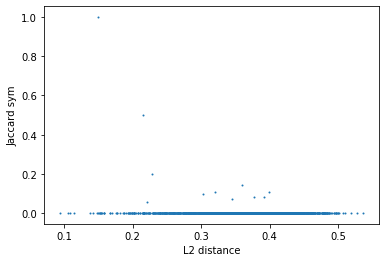

In [150]:
plt.scatter(dist, jaccard_scores, s=1)
plt.xlabel("L2 distance")
plt.ylabel("Jaccard sym")

In [153]:
np.where(np.array(jaccard_scores) > 0)

(array([ 133,  137,  155, 1011, 1029, 1037, 1050, 1141, 1167, 1485, 1648]),)

In [157]:
ind = np.where(np.array(jaccard_scores) > 0)[0]
for pos, value in enumerate(combinations(titles, 2)):
    if pos in ind:
        print(value, jaccard_scores[pos])
        print(categories[value[0]])
        print(categories[value[1]])
        print()

('Josef Özer', 'Gary Weiss') 0.08333333333333333
{'Singers', 'People by status', 'People by ethnic or national descent', 'Music by ethnicity'}
{'People by status', 'American writers', 'Life', 'Jews by country', 'Alumni by university or college in the United States by state', 'Researchers', 'Organized crime', 'Writers by genre', 'Non-fiction writers by nationality'}

('Josef Özer', 'Fredrick Federley') 0.1111111111111111
{'Singers', 'People by status', 'People by ethnic or national descent', 'Music by ethnicity'}
{'Government of Sweden', 'People by status', 'Politicians', 'Writers by nationality', 'Politicians by nationality and party', 'Members of the European Parliament by party'}

('Josef Özer', 'Lee Jung-won') 0.14285714285714285
{'Singers', 'People by status', 'People by ethnic or national descent', 'Music by ethnicity'}
{'Association football players by nationality', 'People by status', 'Association football players', 'Association football players by competition'}

('Gary Weiss', 

In [160]:
ind = np.where(dist < 0.15)[0]
for pos, value in enumerate(combinations(titles, 2)):
    if pos in ind:
        print(value, dist[pos])
        print(categories[value[0]])
        print(categories[value[1]])
        print()

('Craugastor lauraster', 'Amazonian red-sided opossum') 0.11427154418750317
{'Vertebrates by classification'}
{'Vertebrates by country', 'Mammals by classification', 'Fauna by country', 'Species described in the 19th century'}

('Truman the Tiger', 'Kokomo High School') 0.14256729534303883
{'College sports teams in the United States by team', 'NCAA Division I conferences'}
{'Schools in the United States by county'}

('Lampert of Hungary', 'Gualberto Piangatelli') 0.14916865815907088
{'Divided regions', 'High Middle Ages', 'Middle Ages by country', 'Nobility by nationality and title', '1st-millennium establishments'}
{'History of Italy'}

('Hugh Pembroke Vowles', 'Devon Record Offices') 0.10884958496760276
{'People by district in England', 'Science and technology in the United Kingdom'}
{'History of England by county', 'History organizations', 'Organisations based in England by county', 'Rail transport in England', 'Education in England by county', 'Unitary authority districts of Englan